In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf


In [2]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
importlib.reload(mf)

<module 'math_functions' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\math_functions.py'>

In [3]:
folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Apresentaçoes/Experiments/20240605_Effect of light cycle/figures/"

# Day 1 - sequence artifact corrected with day 2

In [4]:
names_1 = ["20240603_effect_day_vitesse_photochimique_1", "20240603_effect_day_vitesse_photochimique_2", "20240603_effect_day_vitesse_photochimique_2_repeat", "20240603_effect_day_vitesse_photochimique_3"]
PWM_rel_1 = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]
PWM_rel_first = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.8, 1]
flashes_1 = ["E15", "E15", "E15", "E15"]
records_1 = tools.create_record_list("31-40")
records_first = tools.create_record_list("31-39")
times = [2.5, 5.5, 6, 9]

In [5]:
experiments_1 = []
for i, name in enumerate(names_1):
    experiments_1.append(ExperimentClass.Experiment(name, "JTS"))
    
## Get sequence artifact from day 2 and correct the length to allow for comparison
get_artefact_from = "20240604_effect_day_vitesse_photochimique_2"
artefact_exp = ExperimentClass.Experiment(get_artefact_from, "JTS")
seq_artefact = artefact_exp.clean_data[artefact_exp.records.index("E33")]


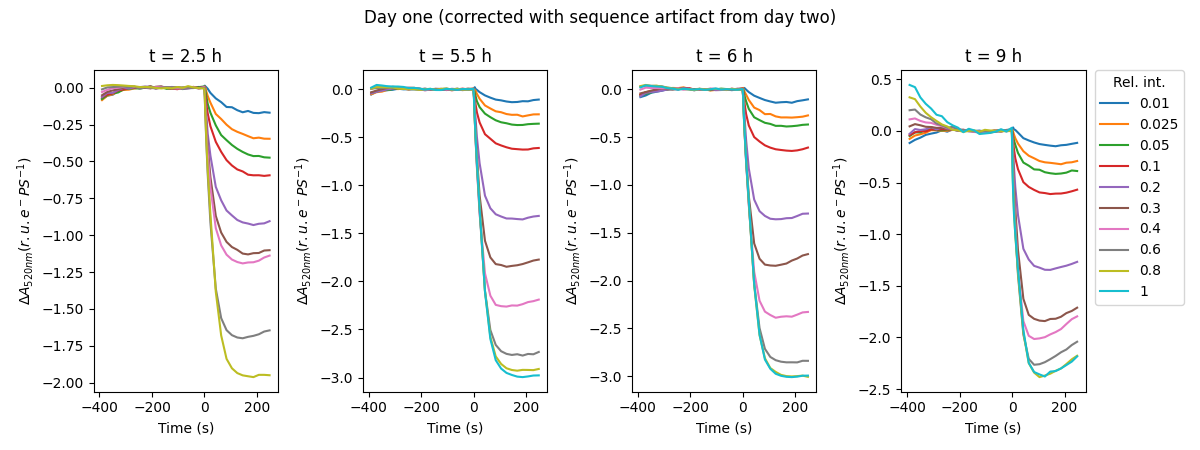

In [6]:
flash_calib = []
fig, ax = plt.subplots(1, len(names_1), figsize = (12,4.5))
fig.suptitle("Day one (corrected with sequence artifact from day two)")
for i, experiment in enumerate(experiments_1):
    flash_calib.append(experiment.clean_data[experiment.records.index(flashes_1[i])][4] - experiment.clean_data[experiment.records.index(flashes_1[i])][3])
    ax[i].set_title(f"t = {times[i]} h")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("$ΔA_{ 520 nm} (r. u. e^- PS^{-1})$")
    if i == 0:
        records = records_first
        PWM_rel = PWM_rel_first
    else:
        records = records_1
        PWM_rel = PWM_rel_1
    for j, k in enumerate(records):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - seq_artefact[0:len(experiment.clean_data[experiment.records.index(k)])]
        y_all_data = y_all_data/flash_calib[i]
        ax[i].plot(experiment.clean_times[experiment.records.index(k)], y_all_data, label = f"{PWM_rel[j]}")
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = "Rel. int.")

fig.tight_layout()

fig.savefig(folder + "day_one_corrected_raw_data.png", dpi = 300)
        
    

In [7]:
start = -10
stop = 200
num = 50
index_stop_fit = 32
index_start_fit = 20

Ek_1 = []
Ek_err_1 = []
vitesse_1 = []
xfit_1 = []
yfit_1 = []
err_fit_1 = []

for i, experiment in enumerate(experiments_1):
    vitesse_1.append([])
    if i == 0:
        records = records_first
    else:
        records = records_1
    for j, k in enumerate(records):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - seq_artefact[0:len(experiment.clean_data[experiment.records.index(k)])]
        y_all_data = y_all_data/flash_calib[i]
        y_data = y_all_data[index_start_fit:index_stop_fit]
        x_data = experiment.clean_times[experiment.records.index(k)][index_start_fit:index_stop_fit]
        popt, x, y =  tools.exp_decay_fit(x_data, y_data, start, stop, num, p0=[0, 100, 0])
        vitesse_1[i].append(-1000*popt[0]/popt[1])
    
    if i == 0:
        PWM_rel = PWM_rel_first
    else:
        PWM_rel = PWM_rel_1

    popt, pcov, x, y = tools.Ek_fit(PWM_rel, vitesse_1[i], 0, 1, 50, p0 = [0, 100])
    xfit_1.append(x)
    yfit_1.append(y)
    err_fit_1.append(tools.my_err(x, popt, pcov, mf.Ek))
    Ek_1.append(popt[1])
    Ek_err_1.append(np.sqrt(np.diag(pcov))[1])
            

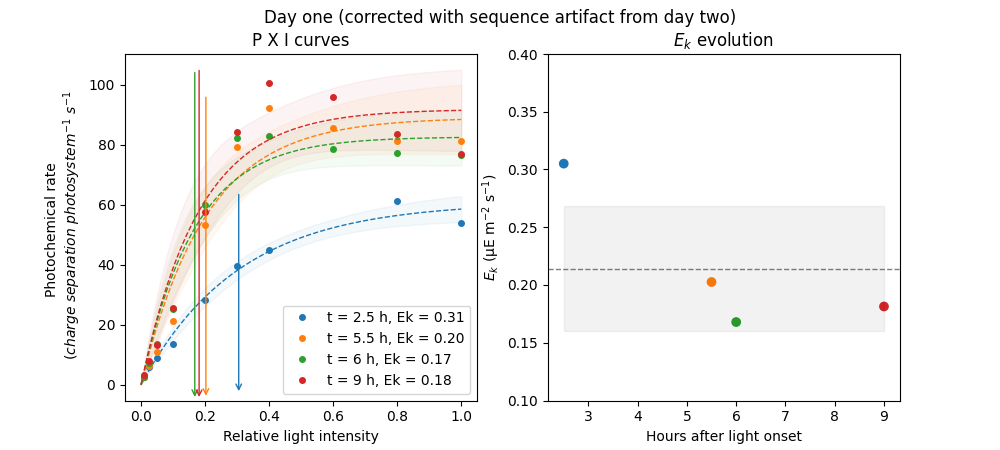

In [8]:
fig, ax = plt.subplots(1,2, figsize = (10,4.5))
fig.suptitle("Day one (corrected with sequence artifact from day two)")
colors = []
for i in range(len(names_1)):
    if i == 0:
        PWM_rel = PWM_rel_first
    else:
        PWM_rel = PWM_rel_1
    colors.append(mcolors.to_rgba(f"C{i}"))
    ax[0].plot(PWM_rel, vitesse_1[i],'o', markersize = 4, label = f"t = {times[i]} h, Ek = {Ek_1[i]:.2f}", color=colors[i])
    ax[0].plot(xfit_1[i], yfit_1[i], '--', color='C'+str(i), linewidth = 1)
    ax[0].annotate("", xy=(Ek_1[i], ax[0].get_ylim()[0]), xytext=(Ek_1[i], ax[0].get_ylim()[1]), arrowprops=dict(arrowstyle="->", color=colors[i], linewidth = 1))
    ax[0].fill_between(xfit_1[i], yfit_1[i] - 1.94*err_fit_1[i], yfit_1[i] + 1.94*err_fit_1[i], alpha=0.05, color = colors[i])

ax[0].set_title("P X I curves")
ax[0].legend()
ax[0].set_xlabel("Relative light intensity")
ax[0].set_ylabel("Photochemical rate \n ($charge$ $separation$ $photosystem^{-1}$ $s^{-1}$")

ax[1].scatter(times, Ek_1, c = colors)
ax[1].axhline(y = np.mean(Ek_1), color = 'k', alpha = 0.5, linestyle = '--', linewidth = 1)
ax[1].text(times[-1], 0.2*np.mean(Ek_1), f"$E_k$ = {np.mean(Ek_1):.2f} ± {np.std(Ek_1):.2f}", ha='right', va='bottom', fontsize=10, color='k')
ax[1].fill_between(times, np.mean(Ek_1) - np.std(Ek_1), np.mean(Ek_1) + np.std(Ek_1), alpha=0.05, color = 'k')
ax[1].set_xlabel("Hours after light onset")
ax[1].set_ylabel("$E_{k}$ (µE m$^{-2}$ s$^{-1}$)")
ax[1].set_title("$E_{k}$ evolution")
ax[1].set_ylim([0.1,0.4])


fig.savefig(folder + "day_one_corrected_PxI.png", dpi = 300)


# Day 2

In [9]:
names_2 = ["20240604_effect_day_vitesse_photochimique_1", "20240604_effect_day_vitesse_photochimique_2", "20240604_effect_day_vitesse_photochimique_3"]
PWM_rel_2 = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]
flashes_2 = ["E15", "E15", "E22"]
sequence_artifact_2 = ["E33", "E33", "E33"]
records_2 = tools.create_record_list("51-60")
times_2 = [2.5, 7, 10]

In [10]:
experiments_2 = []
for i, name in enumerate(names_2):
    experiments_2.append(ExperimentClass.Experiment(name, "JTS"))
    
# Get flash artifact from the 3rd point of second day to apply to the first points

flash_artifact = experiments_2[2].clean_data[experiments_2[2].records.index("E20")]

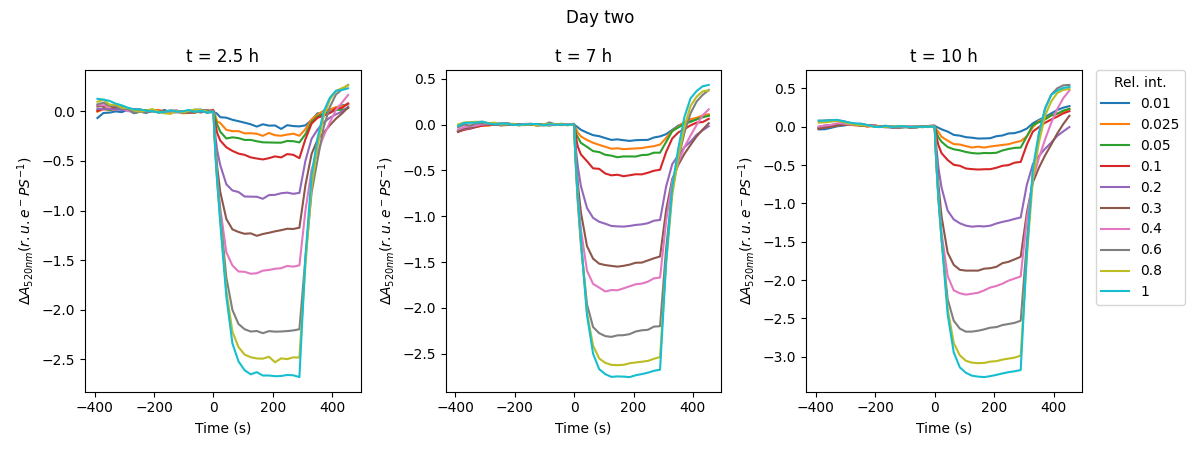

In [11]:
flash_calib = []
fig, ax = plt.subplots(1, len(names_2), figsize = (12,4.5))
fig.suptitle("Day two")
for i, experiment in enumerate(experiments_2):
    flash = experiment.clean_data[experiment.records.index(flashes_2[i])] - flash_artifact
    flash_calib.append(flash[4] - flash[3])
    ax[i].set_title(f"t = {times_2[i]} h")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("$ΔA_{ 520 nm} (r. u. e^- PS^{-1})$")
    for j, k in enumerate(records_2):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - experiment.clean_data[experiment.records.index(sequence_artifact_2[i])]
        y_all_data = y_all_data/flash_calib[i]
        ax[i].plot(experiment.clean_times[experiment.records.index(k)], y_all_data, label = f"{PWM_rel[j]}")
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = "Rel. int.")

fig.tight_layout()

fig.savefig(folder + "day_two_raw_data.png", dpi = 300)
        
    

In [12]:
start = -10
stop = 200
num = 50
index_stop_fit = 32
index_start_fit = 20

Ek_2 = []
Ek_err_2 = []
vitesse_2 = []
xfit_2 = []
yfit_2 = []
err_fit_2 = []

for i, experiment in enumerate(experiments_2):
    vitesse_2.append([])
    for j, k in enumerate(records_2):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - experiment.clean_data[experiment.records.index(sequence_artifact_2[i])]
        y_all_data = y_all_data/flash_calib[i]
        y_data = y_all_data[index_start_fit:index_stop_fit]
        x_data = experiment.clean_times[experiment.records.index(k)][index_start_fit:index_stop_fit]
        popt, x, y =  tools.exp_decay_fit(x_data, y_data, start, stop, num, p0=[0, 100, 0])
        vitesse_2[i].append(-1000*popt[0]/popt[1])
    
    popt, pcov, x, y = tools.Ek_fit(PWM_rel, vitesse_2[i], 0, 1, 50, p0 = [0, 100])
    xfit_2.append(x)
    yfit_2.append(y)
    err_fit_2.append(tools.my_err(x, popt, pcov, mf.Ek))
    Ek_2.append(popt[1])
    Ek_err_2.append(np.sqrt(np.diag(pcov))[1])
            

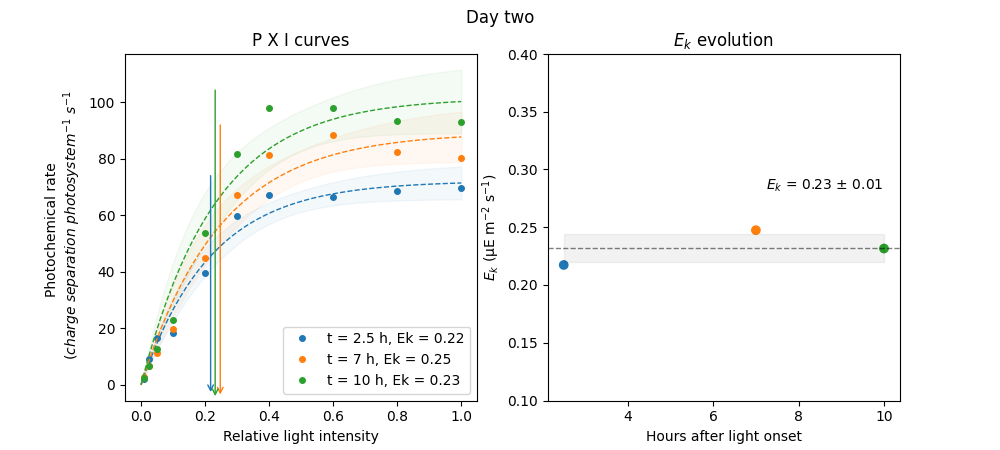

In [13]:
fig, ax = plt.subplots(1,2, figsize = (10,4.5))
fig.suptitle("Day two")
colors = []
for i in range(len(names_2)):
    colors.append(mcolors.to_rgba(f"C{i}"))
    ax[0].plot(PWM_rel, vitesse_2[i],'o', markersize = 4, label = f"t = {times_2[i]} h, Ek = {Ek_2[i]:.2f}", color=colors[i])
    ax[0].plot(xfit_2[i], yfit_2[i], '--', color='C'+str(i), linewidth = 1)
    ax[0].annotate("", xy=(Ek_2[i], ax[0].get_ylim()[0]), xytext=(Ek_2[i], ax[0].get_ylim()[1]), arrowprops=dict(arrowstyle="->", color=colors[i], linewidth = 1))
    ax[0].fill_between(xfit_2[i], yfit_2[i] - 1.94*err_fit_2[i], yfit_2[i] + 1.94*err_fit_2[i], alpha=0.05, color = colors[i])

ax[0].set_title("P X I curves")
ax[0].legend()
ax[0].set_xlabel("Relative light intensity")
ax[0].set_ylabel("Photochemical rate \n ($charge$ $separation$ $photosystem^{-1}$ $s^{-1}$")

ax[1].scatter(times_2, Ek_2, c = colors)
ax[1].axhline(y = np.mean(Ek_2), color = 'k', alpha = 0.5, linestyle = '--', linewidth = 1)
ax[1].text(times_2[-1], np.mean(Ek_2)+0.2*np.mean(Ek_2), f"$E_k$ = {np.mean(Ek_2):.2f} ± {np.std(Ek_2):.2f}", ha='right', va='bottom', fontsize=10, color='k')
ax[1].fill_between(times_2, np.mean(Ek_2) - np.std(Ek_2), np.mean(Ek_2) + np.std(Ek_2), alpha=0.05, color = 'k')
ax[1].set_xlabel("Hours after light onset")
ax[1].set_ylabel("$E_{k}$ (µE m$^{-2}$ s$^{-1}$)")
ax[1].set_title("$E_{k}$ evolution")
ax[1].set_ylim([0.1,0.4])

fig.savefig(folder + "day_two_PxI.png", dpi = 300)

# Day 3 - continous light control

In [14]:
names_3 = ["20240605_effect_day_vitesse_photochimique_1", "20240605_effect_day_vitesse_photochimique_2", "20240605_effect_day_vitesse_photochimique_3"]
PWM_rel_3 = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]
flashes_3 = ["E19", "E11", "E12"]
flash_artifact_3 = ["E31", "E31", "E31"]
sequence_artifact_3 = ["E33", "E33", "E33"]
records_3 = tools.create_record_list("51-60")
times_3 = [2.5, 5.5, 8]

In [15]:
experiments_3 = []
for i, name in enumerate(names_3):
    experiments_3.append(ExperimentClass.Experiment(name, "JTS"))

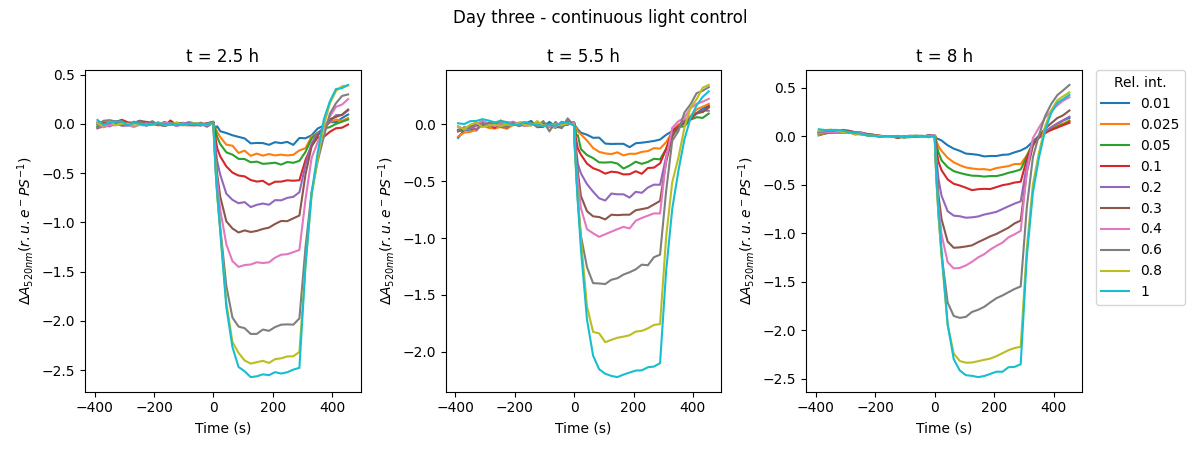

In [16]:
flash_calib = []
fig, ax = plt.subplots(1, len(names_3), figsize = (12,4.5))
fig.suptitle("Day three - continuous light control") 
for i, experiment in enumerate(experiments_3):
    flash = experiment.clean_data[experiment.records.index(flashes_3[i])] - experiment.clean_data[experiment.records.index(flash_artifact_3[i])]
    flash_calib.append(flash[4] - flash[3])
    ax[i].set_title(f"t = {times_3[i]} h")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("$ΔA_{ 520 nm} (r. u. e^- PS^{-1})$")
    for j, k in enumerate(records_3):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - experiment.clean_data[experiment.records.index(sequence_artifact_3[i])]
        y_all_data = y_all_data/flash_calib[i]
        ax[i].plot(experiment.clean_times[experiment.records.index(k)], y_all_data, label = f"{PWM_rel_3[j]}")
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = "Rel. int.")

fig.tight_layout()
fig.savefig(folder + "day_three_raw_data.png", dpi = 300)
        
    

In [17]:
start = -10
stop = 200
num = 50
index_stop_fit = 32
index_start_fit = 20

Ek_3 = []
Ek_err_3 = []
vitesse_3 = []
xfit_3 = []
yfit_3 = []
err_fit_3 = []

for i, experiment in enumerate(experiments_3):
    vitesse_3.append([])
    for j, k in enumerate(records_3):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - experiment.clean_data[experiment.records.index(sequence_artifact_3[i])]
        y_all_data = y_all_data/flash_calib[i]
        y_data = y_all_data[index_start_fit:index_stop_fit]
        x_data = experiment.clean_times[experiment.records.index(k)][index_start_fit:index_stop_fit]
        popt, x, y =  tools.exp_decay_fit(x_data, y_data, start, stop, num, p0=[0, 100, 0])
        vitesse_3[i].append(-1000*popt[0]/popt[1])
    
    popt, pcov, x, y = tools.Ek_fit(PWM_rel_3, vitesse_3[i], 0, 1, 50, p0 = [0, 100])
    xfit_3.append(x)
    yfit_3.append(y)
    err_fit_3.append(tools.my_err(x, popt, pcov, mf.Ek))
    Ek_3.append(popt[1])
    Ek_err_3.append(np.sqrt(np.diag(pcov))[1])
            

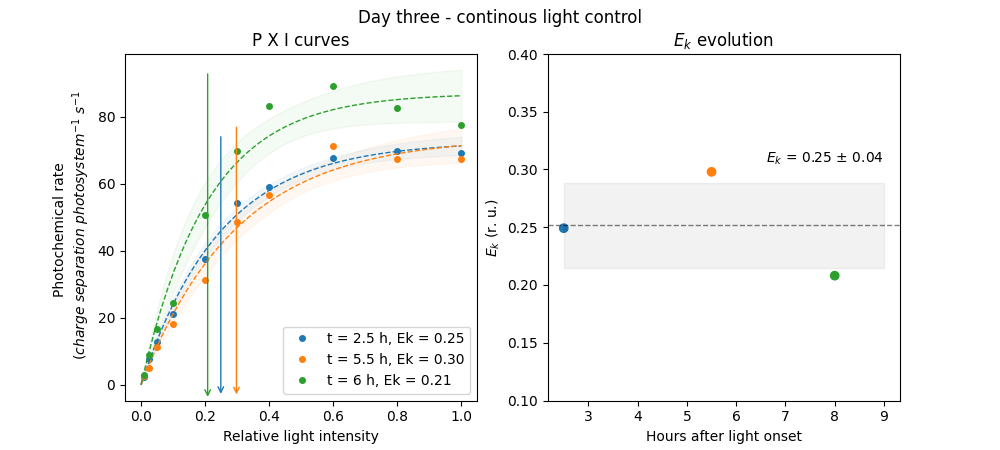

In [18]:
fig, ax = plt.subplots(1,2, figsize = (10,4.5))
fig.suptitle("Day three - continous light control")
colors = []
for i in range(len(names_3)):
    colors.append(mcolors.to_rgba(f"C{i}"))
    ax[0].plot(PWM_rel_3, vitesse_3[i],'o', markersize = 4, label = f"t = {times[i]} h, Ek = {Ek_3[i]:.2f}", color=colors[i])
    ax[0].plot(xfit_3[i], yfit_3[i], '--', color='C'+str(i), linewidth = 1)
    ax[0].annotate("", xy=(Ek_3[i], ax[0].get_ylim()[0]), xytext=(Ek_3[i], ax[0].get_ylim()[1]), arrowprops=dict(arrowstyle="->", color=colors[i], linewidth = 1))
    ax[0].fill_between(xfit_3[i], yfit_3[i] - 1.94*err_fit_3[i], yfit_3[i] + 1.94*err_fit_3[i], alpha=0.05, color = colors[i])

ax[0].set_title("P X I curves")
ax[0].legend()
ax[0].set_xlabel("Relative light intensity")
ax[0].set_ylabel("Photochemical rate \n ($charge$ $separation$ $photosystem^{-1}$ $s^{-1}$")

ax[1].scatter(times_3, Ek_3, c = colors)
ax[1].axhline(y = np.mean(Ek_3), color = 'k', alpha = 0.5, linestyle = '--', linewidth = 1)
ax[1].text(times[-1], np.mean(Ek_3)+0.2*np.mean(Ek_3), f"$E_k$ = {np.mean(Ek_3):.2f} ± {np.std(Ek_3):.2f}", ha='right', va='bottom', fontsize=10, color='k')
ax[1].fill_between(times, np.mean(Ek_3) - np.std(Ek_3), np.mean(Ek_3) + np.std(Ek_3), alpha=0.05, color = 'k')
ax[1].set_xlabel("Hours after light onset")
ax[1].set_ylabel("$E_{k}$ (r. u.)")
ax[1].set_title("$E_{k}$ evolution")
ax[1].set_ylim([0.1,0.4])

fig.savefig(folder + "day_three_PxI.png", dpi = 300)

# Day 4 - continous light control

In [19]:
names_4 = ["20240613_effect_day_vitesse_photochimique"]
PWM_rel_4 = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]
flashes_4 = ["E12"]
flash_artifact_4 = ["E31"]
sequence_artifact_4 = ["E33"]
records_4 = tools.create_record_list("51-60")
times_4 = [7.5]

In [20]:
experiments_4 = []
for i, name in enumerate(names_4):
    experiments_4.append(ExperimentClass.Experiment(name, "JTS"))

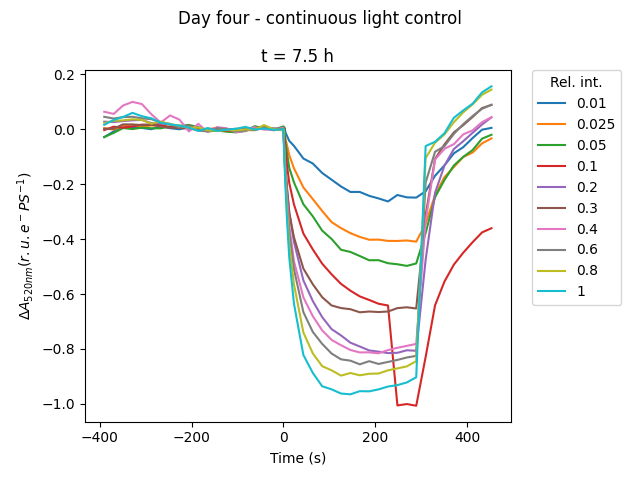

In [21]:
flash_calib = []
fig, ax = plt.subplots(1, len(names_4))
fig.suptitle("Day four - continuous light control") 
for i, experiment in enumerate(experiments_4):
    flash = experiment.clean_data[experiment.records.index(flashes_4[i])] - experiment.clean_data[experiment.records.index(flash_artifact_4[i])]
    flash_calib.append(flash[4] - flash[3])
    ax.set_title(f"t = {times_4[i]} h")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("$ΔA_{ 520 nm} (r. u. e^- PS^{-1})$")
    for j, k in enumerate(records_4):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - experiment.clean_data[experiment.records.index(sequence_artifact_4[i])]
        y_all_data = y_all_data/flash_calib[i]
        ax.plot(experiment.clean_times[experiment.records.index(k)], y_all_data, label = f"{PWM_rel_3[j]}")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = "Rel. int.")

fig.tight_layout()
fig.savefig(folder + "day_four_raw_data.png", dpi = 300)
        
    

In [22]:
start = -10
stop = 200
num = 50
index_stop_fit = 27
index_start_fit = 20

Ek_4 = []
Ek_err_4 = []
vitesse_4 = []
xfit_4 = []
yfit_4 = []
err_fit_4 = []

for i, experiment in enumerate(experiments_4):
    vitesse_4.append([])
    for j, k in enumerate(records_4):
        y_all_data = experiment.clean_data[experiment.records.index(k)] - experiment.clean_data[experiment.records.index(sequence_artifact_4[i])]
        y_all_data = y_all_data/flash_calib[i]
        y_data = y_all_data[index_start_fit:index_stop_fit]
        x_data = experiment.clean_times[experiment.records.index(k)][index_start_fit:index_stop_fit]
        popt, x, y =  tools.exp_decay_fit(x_data, y_data, start, stop, num, p0=[0, 100, 0])
        vitesse_4[i].append(-1000*popt[0]/popt[1])
    
    popt, pcov, x, y = tools.Ek_fit(PWM_rel_4, vitesse_4[i], 0, 1, 50, p0 = [0, 100])
    xfit_4.append(x)
    yfit_4.append(y)
    err_fit_4.append(tools.my_err(x, popt, pcov, mf.Ek))
    Ek_4.append(popt[1])
    Ek_err_4.append(np.sqrt(np.diag(pcov))[1])
            

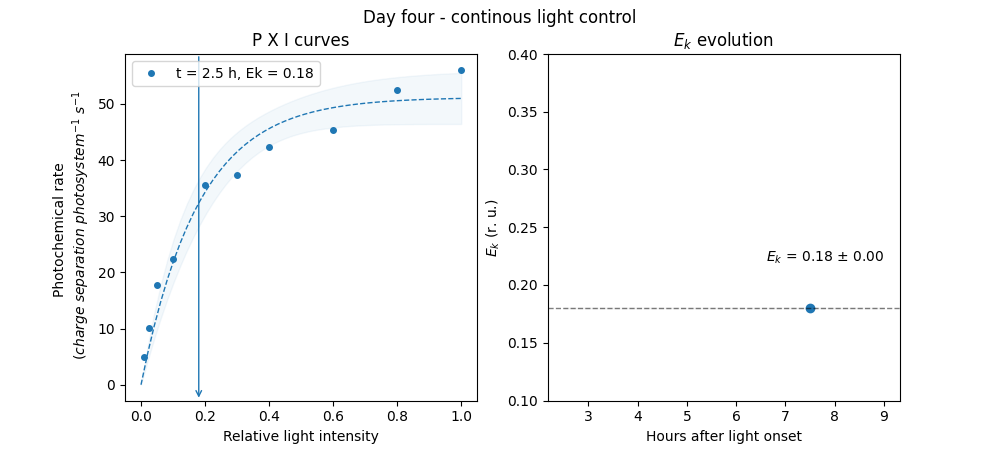

In [23]:
fig, ax = plt.subplots(1,2, figsize = (10,4.5))
fig.suptitle("Day four - continous light control")
colors = []
for i in range(len(names_4)):
    colors.append(mcolors.to_rgba(f"C{i}"))
    ax[0].plot(PWM_rel_4, vitesse_4[i],'o', markersize = 4, label = f"t = {times[i]} h, Ek = {Ek_4[i]:.2f}", color=colors[i])
    ax[0].plot(xfit_4[i], yfit_4[i], '--', color='C'+str(i), linewidth = 1)
    ax[0].annotate("", xy=(Ek_4[i], ax[0].get_ylim()[0]), xytext=(Ek_4[i], ax[0].get_ylim()[1]), arrowprops=dict(arrowstyle="->", color=colors[i], linewidth = 1))
    ax[0].fill_between(xfit_4[i], yfit_4[i] - 1.94*err_fit_4[i], yfit_4[i] + 1.94*err_fit_4[i], alpha=0.05, color = colors[i])

ax[0].set_title("P X I curves")
ax[0].legend()
ax[0].set_xlabel("Relative light intensity")
ax[0].set_ylabel("Photochemical rate \n ($charge$ $separation$ $photosystem^{-1}$ $s^{-1}$")

ax[1].scatter(times_4, Ek_4, c = colors)
ax[1].axhline(y = np.mean(Ek_4), color = 'k', alpha = 0.5, linestyle = '--', linewidth = 1)
ax[1].text(times[-1], np.mean(Ek_4)+0.2*np.mean(Ek_4), f"$E_k$ = {np.mean(Ek_4):.2f} ± {np.std(Ek_4):.2f}", ha='right', va='bottom', fontsize=10, color='k')
ax[1].fill_between(times, np.mean(Ek_4) - np.std(Ek_4), np.mean(Ek_4) + np.std(Ek_4), alpha=0.05, color = 'k')
ax[1].set_xlabel("Hours after light onset")
ax[1].set_ylabel("$E_{k}$ (r. u.)")
ax[1].set_title("$E_{k}$ evolution")
ax[1].set_ylim([0.1,0.4])

fig.savefig(folder + "day_four_PxI.png", dpi = 300)

In [24]:
all_experiments = [experiments_1, experiments_2, experiments_3, experiments_4]
all_Ek = [Ek_1, Ek_2, Ek_3, Ek_4]
all_Ek_err = [Ek_err_1, Ek_err_2, Ek_err_3, Ek_err_4]
all_times = [times, times_2, times_3, times_4]
all_flashes = [flashes_1, flashes_2, flashes_3, flashes_4]
all_sequence_artifact = [sequence_artifact_2, sequence_artifact_3, sequence_artifact_4]
all_vitesse = [vitesse_1, vitesse_2, vitesse_3, vitesse_4]

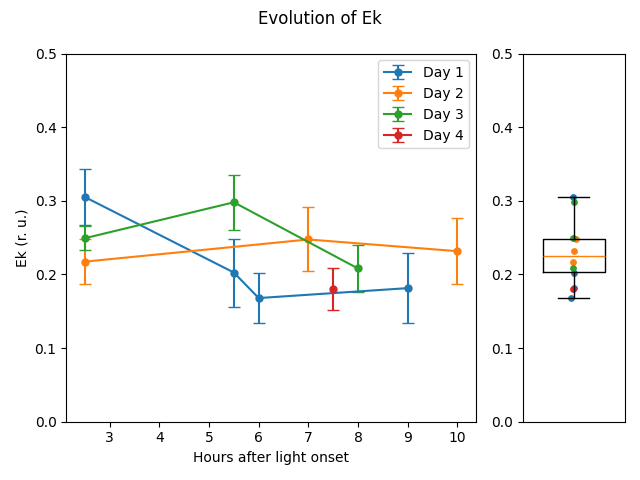

In [25]:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]})
fig.suptitle("Evolution of Ek")
appended_Ek = np.array(all_Ek[0] + all_Ek[1] + all_Ek[2])

for i, experiments in enumerate(all_experiments):
    ax[0].errorbar(all_times[i], all_Ek[i], yerr = all_Ek_err[i], fmt= '-o', label = f"Day {i+1}", capsize=4, markersize=5)
    x = np.random.normal(1, 0.02, size=len(all_Ek[i]))
    ax[1].scatter(x, all_Ek[i], s =15)


ax[1].boxplot(appended_Ek, labels = [""], widths = 0.6)
ax[1].set_ylim(0,0.5)
ax[1].set_xticks([])

ax[0].set_ylim(0,0.5)
ax[0].set_xlabel("Hours after light onset")
ax[0].set_ylabel("Ek (r. u.)")
ax[0].legend()
fig.tight_layout()

fig.savefig(folder + "Ek_evolution.png", dpi = 300)

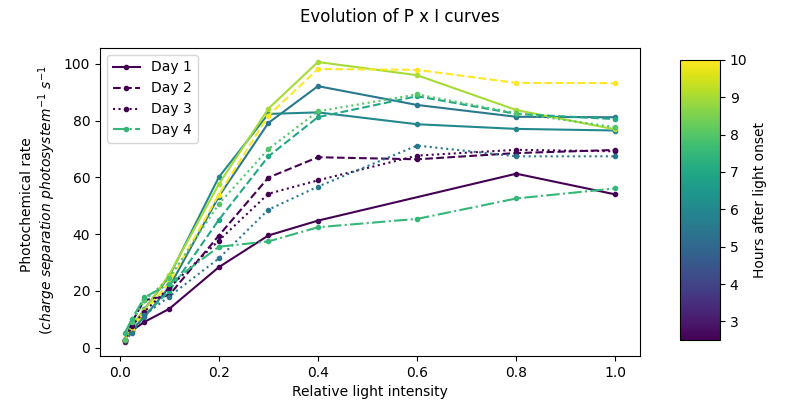

In [26]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle("Evolution of P x I curves")

# Flatten all_times and normalize it for color mapping
all_times_flat = [time for sublist in all_times for time in sublist]
norm = Normalize(min(all_times_flat), max(all_times_flat))
cmap = cm.viridis

# Define a list of linestyles
linestyles = ['-', '--', ':', '-.']

for i, vitesse in enumerate(all_vitesse):
    for j in range(len(vitesse)):
        if i == 0 and j == 0:
            PWM_rel = PWM_rel_first
        else:
            PWM_rel = PWM_rel_1
        
        color = cmap(norm(all_times[i][j]))
        linestyle = linestyles[i % len(linestyles)]  # Select linestyle based on day
        if j == 0:
            ax.plot(PWM_rel, vitesse[j], 'o', markersize = 3, color=color, linestyle=linestyle, label = f"Day {i+1}")
        else:
            ax.plot(PWM_rel, vitesse[j], 'o', markersize = 3, color=color, linestyle=linestyle)

ax.set_xlabel("Relative light intensity")
ax.set_ylabel("Photochemical rate \n ($charge$ $separation$ $photosystem^{-1}$ $s^{-1}$")

fig.subplots_adjust(right=0.8)

# Create a colorbar
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('Hours after light onset')
ax.legend()

fig.savefig(folder + "PxI_evolution.png", dpi = 300)

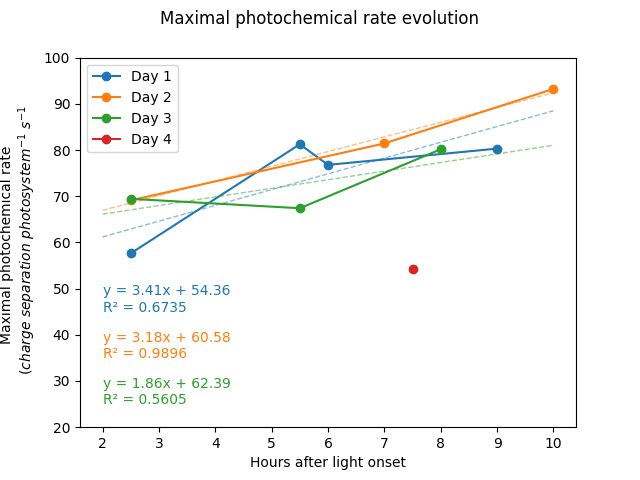

In [27]:
fig, ax = plt.subplots()
max_rate = []
height = [45, 35, 25]
for i, vitesse in enumerate(all_vitesse):
    max_rate.append([])
    for j in range(len(vitesse)):
        max_rate[i].append(np.mean(vitesse[j][-2:]))
    ax.plot(all_times[i], max_rate[i], '-o', label = f"Day {i+1}", color = f"C{i}")
    if i != 3: 
        popt, xfit, yfit, r_squared = tools.lin_fit(all_times[i], max_rate[i], 2, 10, 10)
        ax.plot(xfit, yfit, '--', color = f"C{i}", linewidth = 1, alpha = 0.5)
        ax.text(2, height[i], f"y = {popt[0]:.2f}x + {popt[1]:.2f} \nR² = {r_squared:.4f}", fontsize=10, color=f"C{i}")
    
ax.set_xlabel("Hours after light onset")
ax.set_ylabel("Maximal photochemical rate \n ($charge$ $separation$ $photosystem^{-1}$ $s^{-1}$")
ax.set_ylim(20, 100)
ax.legend()
fig.suptitle("Maximal photochemical rate evolution")
        

fig.savefig(folder + "max_rate_evolution.png", dpi = 300)

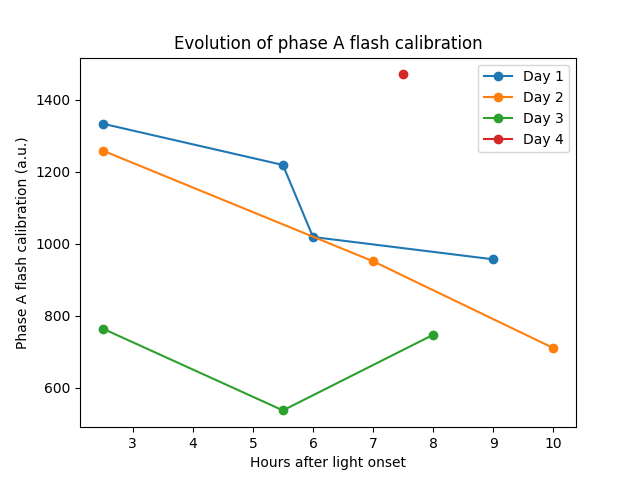

In [28]:
fig, ax = plt.subplots()
flash_calib = []
for i, experiments in enumerate(all_experiments):
    flash_calib.append([])
    for j, exp in enumerate(experiments):
        flash_calib[i].append(exp.clean_data[exp.records.index(all_flashes[i][j])][4] - exp.clean_data[exp.records.index(all_flashes[i][j])][3])
    ax.plot(all_times[i], flash_calib[i], '-o', label = f"Day {i+1}")

ax.set_title("Evolution of phase A flash calibration")
ax.set_xlabel("Hours after light onset")
ax.set_ylabel("Phase A flash calibration (a.u.)")
ax.legend()

fig.savefig(folder + "flash_calibration_evolution.png", dpi = 300)

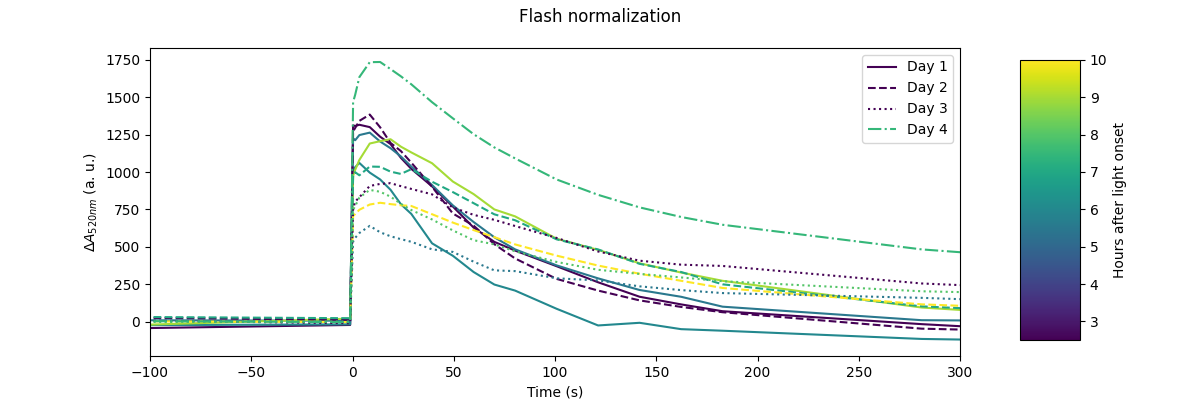

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Flash normalization")

# Flatten all_times and normalize it for color mapping
all_times_flat = [time for sublist in all_times for time in sublist]
norm = Normalize(min(all_times_flat), max(all_times_flat))
cmap = cm.viridis

# Define a list of linestyles
linestyles = ['-', '--', ':', '-.']

for i, experiments in enumerate(all_experiments):
    for j, exp in enumerate(experiments):
        color = cmap(norm(all_times[i][j]))
        linestyle = linestyles[i % len(linestyles)]  # Select linestyle based on day
        if j == 0:
            ax.plot(exp.clean_times[exp.records.index(all_flashes[i][j])], exp.clean_data[exp.records.index(all_flashes[i][j])], color = color, linestyle =  linestyle ,label = f"Day {i+1}")
        else:
            ax.plot(exp.clean_times[exp.records.index(all_flashes[i][j])], exp.clean_data[exp.records.index(all_flashes[i][j])], color = color, linestyle = linestyle)

ax.set_xlabel("Time (s)")
ax.set_ylabel("$ΔA_{520 nm}$ (a. u.)")
ax.set_xlim(-100, 300)

fig.subplots_adjust(right=0.8)

# Create a colorbar
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('Hours after light onset')
ax.legend()
        
    

In [30]:
flash_calib[3]

[1470.8426949999998]

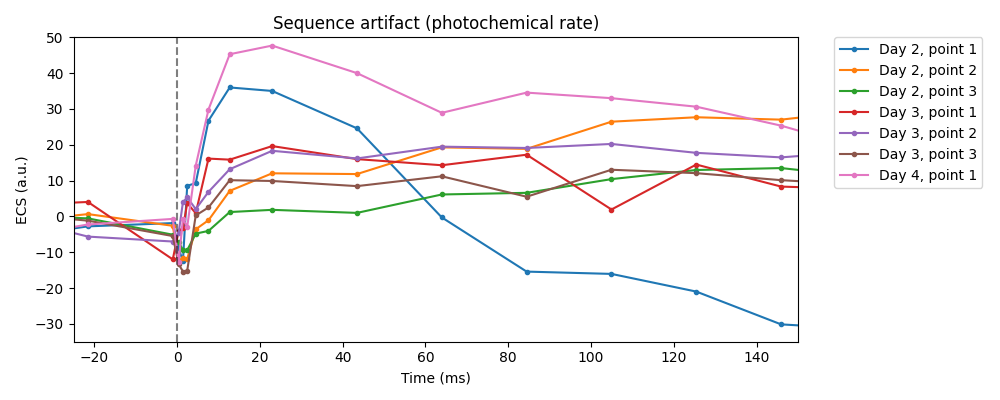

In [31]:
fig, ax = plt.subplots(figsize = (10,4))
for i, experiments in enumerate([experiments_2, experiments_3, experiments_4]):
    for j, exp in enumerate(experiments):
        ax.plot(exp.clean_times[exp.records.index("E33")], exp.clean_data[exp.records.index("E33")], '-o' ,label = f"Day {i+2}, point {j+1}", markersize = 3)
ax.axvline(x = 0, color = 'k', linestyle = '--', alpha = 0.5)

ax.set_xlim(-25, 150)
ax.set_ylim(-35 ,50)

ax.set_title("Sequence artifact (photochemical rate)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ECS (a.u.)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout() 

fig.savefig(folder + "sequence_artifact.png", dpi = 300)

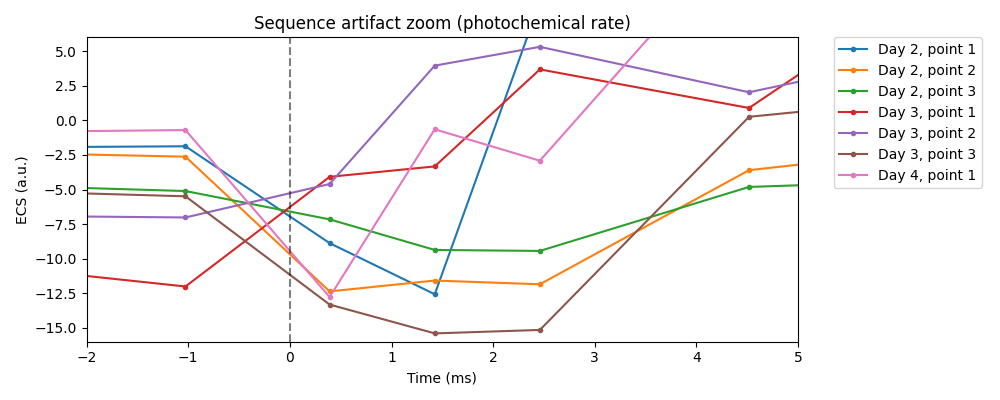

In [32]:
fig, ax = plt.subplots(figsize = (10,4))
for i, experiments in enumerate([experiments_2, experiments_3, experiments_4]):
    for j, exp in enumerate(experiments):
        ax.plot(exp.clean_times[exp.records.index("E33")], exp.clean_data[exp.records.index("E33")], '-o' ,label = f"Day {i+2}, point {j+1}", markersize = 3)

ax.axvline(x = 0, color = 'k', linestyle = '--', alpha = 0.5)

ax.set_xlim(-2, 5)
ax.set_ylim(-16, 6)

ax.set_title("Sequence artifact zoom (photochemical rate)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ECS (a.u.)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout() 

fig.savefig(folder + "sequence_artifact_zoom.png", dpi = 300)

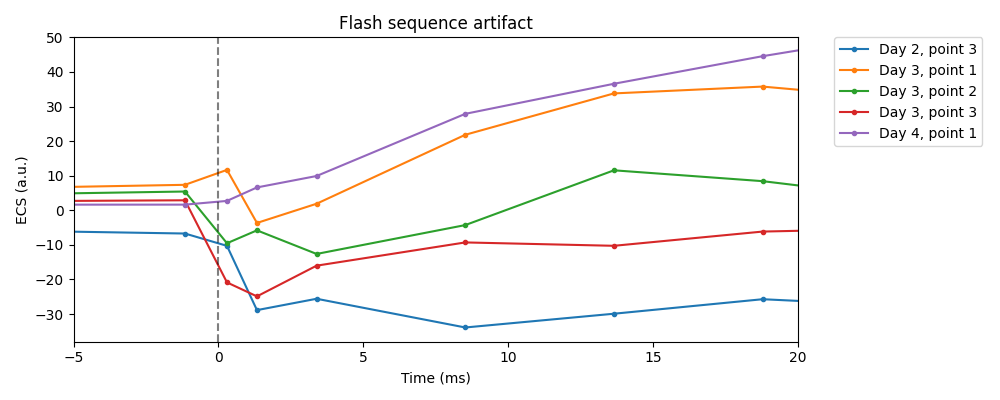

In [33]:
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(experiments_2[2].clean_times[experiments_2[2].records.index("E20")], experiments_2[2].clean_data[experiments_2[2].records.index("E20")], '-o' ,label = f"Day 2, point 3", markersize = 3)
for j, exp in enumerate(experiments_3):
    ax.plot(exp.clean_times[exp.records.index(flash_artifact_3[j])], exp.clean_data[exp.records.index(flash_artifact_3[j])], '-o' ,label = f"Day 3, point {j+1}", markersize = 3)
ax.plot(experiments_4[0].clean_times[experiments_4[0].records.index("E31")], experiments_4[0].clean_data[experiments_4[0].records.index("E31")], '-o' ,label = f"Day 4, point 1", markersize = 3)

ax.axvline(x = 0, color = 'k', linestyle = '--', alpha = 0.5)

ax.set_xlim(-5, 20)
ax.set_ylim(-38, 50)

ax.set_title("Flash sequence artifact")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ECS (a.u.)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout() 

fig.savefig(folder + "flash_artifact.png", dpi = 300)